## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [2]:
from fastai.conv_learner import *
PATH = "data/cifar/"
os.makedirs(PATH,exist_ok=True)

# Data Preparation

In [3]:
# Constants
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))


In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)


# Run only Once 

## Download 
* Download the Files
* Untar the files and move them into data directory
* Split the data into respective class subfolders
- !wget http://pjreddie.com/media/files/cifar.tgz
- !tar xvf cifar.tgz
- !mv cifar data/
- !python process_cifar.py


# Define Architecture

## Refactored

In [5]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

## BatchNorm

In [6]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

## Resnet

In [7]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

## Resnet 2

In [8]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

# Plot Losses

In [9]:
def plot_losses(losses):
    (train_loss,val_loss,acc)=losses
    steps=len(train_loss)
    fig,ax = plt.subplots(2,1,figsize=(8,12))
    ax[0].plot(list(range(steps)),val_loss, label='Validation loss')
    ax[0].plot(list(range(steps)),train_loss, label='Training loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='upper right')
    ax[1].plot(list(range(steps)),acc)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')


# Baseline with 1 Cycle Learning policy

In [10]:
data= get_data(32,256)
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)
learn.lr_find()
learn.sched.plot()


In [11]:
lr=0.01
cycle_len=15
bs=256
num_iterations=int(len(data.trn_y)/bs)+1
arch=Resnet2([16, 32, 64, 128, 256], 10, 0.2)
print(num_iterations)

196


In [12]:
# Summary of Architecture
arch

Resnet2(
  (conv1): BnLayer(
    (conv): Conv2d (3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (layers): ModuleList(
    (0): BnLayer(
      (conv): Conv2d (16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BnLayer(
      (conv): Conv2d (32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): BnLayer(
      (conv): Conv2d (64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (3): BnLayer(
      (conv): Conv2d (128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
  )
  (layers2): ModuleList(
    (0): ResnetLayer(
      (conv): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): ResnetLayer(
      (conv): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): ResnetLayer(
      (conv): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [13]:
data= get_data(32,bs)
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.675179   1.468744   0.4702    
    1      1.450601   1.366227   0.5132                     
    2      1.298715   1.210743   0.5678                     
    3      1.17971    1.077701   0.6169                     
    4      1.091732   1.028288   0.6397                     
    5      0.978176   0.919235   0.6794                      
    6      0.911332   0.896567   0.6842                      
    7      0.85537    0.793205   0.7255                      
    8      0.797175   0.792717   0.7251                      
    9      0.746134   0.744673   0.7447                      
    10     0.683397   0.681532   0.7595                      
    11     0.653043   0.677232   0.7656                      
    12     0.591833   0.614252   0.7856                      
    13     0.546532   0.601749   0.7914                      
    14     0.533906   0.603151   0.7918                      



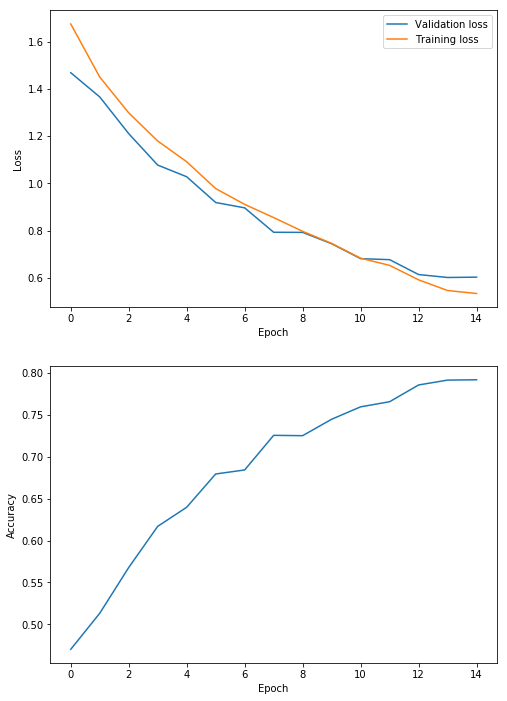

In [15]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=cycle_len, use_clr_beta=(10, 13.68, 0.95, 0.85), wds=1e-4)
train_loss=[learn.sched.losses[i] for i in range(num_iterations-1,cycle_len*num_iterations,num_iterations)]
losses_vannila=(train_loss,learn.sched.val_losses,learn.sched.rec_metrics)
plot_losses(losses_vannila)

In [16]:
del learn

# Vanilla model with CosineAnnealing Fit Method 

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.17727    1.927945   0.3404    
    1      1.531131   1.373096   0.4922                     
    2      1.298452   1.228742   0.5566                     
    3      1.160977   1.1014     0.6102                     
    4      1.050671   0.977708   0.6573                     
    5      0.979301   0.947898   0.6662                      
    6      0.899838   0.854129   0.6958                      
    7      0.8377     0.798847   0.7185                      
    8      0.781122   0.788359   0.7174                      
    9      0.745755   0.76706    0.7294                      
    10     0.712873   0.716946   0.745                       
    11     0.673354   0.721044   0.7464                      
    12     0.653722   0.722477   0.7479                      
    13     0.637007   0.703713   0.7489                      
    14     0.640651   0.690171   0.7556                      



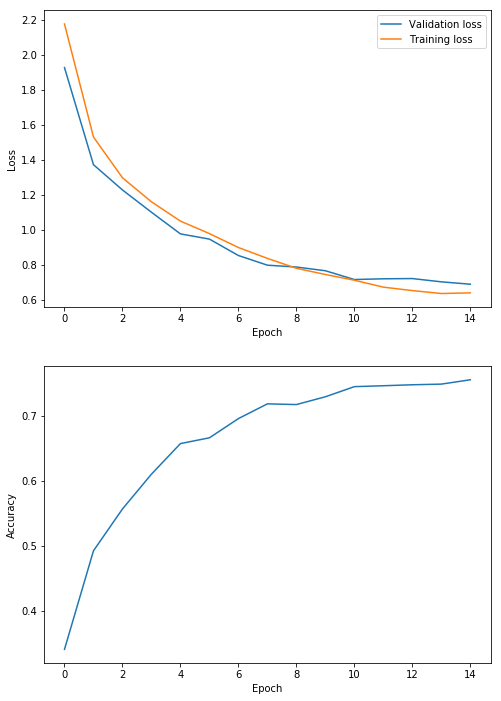

In [17]:
data= get_data(32,bs)
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

learn.fit(lr, 1, cycle_len=cycle_len, wds=1e-4)

train_loss=[learn.sched.losses[i] for i in range(num_iterations-1,cycle_len*num_iterations,num_iterations)]
losses_fit_usual=(train_loss,learn.sched.val_losses,learn.sched.rec_metrics)
plot_losses(losses_fit_usual)

In [18]:
del learn

# Progressive Image Resizing  with constant Batch Size

Sizes: [32, 64, 128]
0 32 256


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.677397   1.540558   0.4507    
    1      1.451289   1.356633   0.5099                     
    2      1.263923   1.173804   0.5765                     
    3      1.101648   1.02118    0.6376                     
    4      0.963357   0.914761   0.679                       

Save Weight Adaptive of_0
1 64 256
Load Weights of _0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.078433   1.038059   0.6357    
    1      0.996126   0.983603   0.6627                      
    3      0.700505   0.616461   0.7851                      
    4      0.600328   0.587719   0.7944                      

Save Weight Adaptive of_1
2 128 256
Load Weights of _1


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.894024   0.745422   0.7461    
    1      0.848915   0.971015   0.6941                      
    2      0.710578   0.692491   0.7674                      
    3      0.597636   0.547862   0.8167                      
    4      0.489358   0.471242   0.8405                      

Save Weight Adaptive of_2


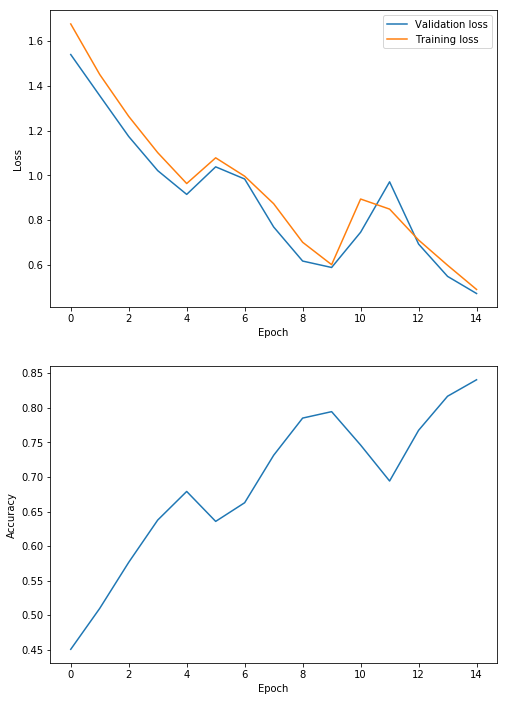

In [19]:
szs= [2**i for i in range(5,8)]
bss=[256]
print(f"Sizes: {szs}")
c_len=math.ceil(cycle_len/len(szs)) # Spliting the  Total Cycles into batches with increased size 
val_loss,train_loss,acc=[],[],[]

for idx,sz in enumerate(szs):
    if len(bss)==1:
        bs=bss[0]
    else:
        bs=bss[idx]
    num_iterations=int(len(data.trn_y)/bs)+1
    print(idx,sz,bs) # debug

    learn = ConvLearner.from_model_data(arch, get_data(sz,bs))
    if idx >= 1 :
        learn.load(f'model_cifar_{idx-1}')
        print(f"Load Weights of _{idx-1}")

    learn.fit(lr, 1, cycle_len=c_len, use_clr_beta=(10, 13.68, 0.95, 0.85), wds=1e-4)
    learn.save(f'model_cifar_{idx}')
    print(f"Save Weight Adaptive of_{idx}")
    val_loss.extend(learn.sched.val_losses)
    train_loss.extend([learn.sched.losses[i] for i in range(num_iterations-1,c_len*num_iterations,num_iterations)])
    acc.extend(learn.sched.rec_metrics)
plot_losses((train_loss,val_loss,acc))
progressive_resizing_loss=(train_loss,val_loss,acc)

In [20]:
del learn

# Progressive Image Upsizing and Batch Downsizing

Sizes: [32, 64, 128],Batch Sizes : [512, 256, 128]
0 32 512


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.10233    0.94208    0.6657    
    1      0.943081   0.833028   0.7                       
    2      0.858101   0.783795   0.7191                    
    3      0.79668    0.747733   0.7304                    
    4      0.744974   0.730952   0.7414                    

Save Weight Adaptive of_0
1 64 256
Load Weights of _0


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.573582   0.566807   0.803     
    1      0.552508   0.593802   0.7989                      
    2      0.52479    0.521354   0.8234                      
    3      0.468476   0.464346   0.843                       
    4      0.394207   0.446895   0.8505                      

Save Weight Adaptive of_1
2 128 128
Load Weights of _1


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.687599   0.624386   0.7978    
    1      0.665623   0.577987   0.7996                      
    2      0.569829   0.483204   0.8355                      
    3      0.463937   0.422813   0.8537                      
    4      0.337935   0.341755   0.8851                      

Save Weight Adaptive of_2


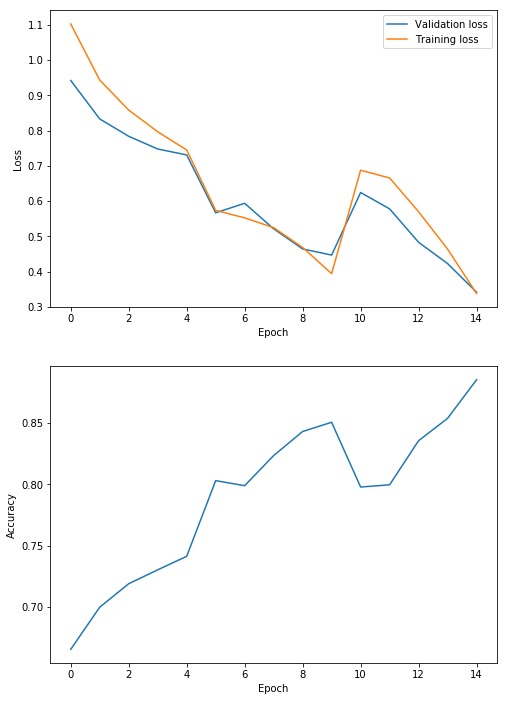

In [21]:
szs= [2**i for i in range(5,8)]

bs=1024
bss=[int(bs*2**-i)for i in range(1,4)] # Decreasing the batch size
print(f"Sizes: {szs},Batch Sizes : {bss}")



c_len=math.ceil(cycle_len/len(szs)) # Spliting the  Total Cycles into batches with increased size 

val_loss,train_loss,acc=[],[],[]

for idx,sz in enumerate(szs):
    if len(bss)==1:
        bs=bss[0]
    else:
        bs=bss[idx]
    num_iterations=int(len(data.trn_y)/bs)+1
    print(idx,sz,bs) # debug

    learn = ConvLearner.from_model_data(arch, get_data(sz,bs))
    if idx >= 1 :
        learn.load(f'model_cifar_{idx-1}')
        print(f"Load Weights of _{idx-1}") # debug

    learn.fit(lr, 1, cycle_len=c_len, use_clr_beta=(10, 13.68, 0.95, 0.85), wds=1e-4)
    learn.save(f'model_cifar_{idx}')
    print(f"Save Weight Adaptive of_{idx}") # debug
    val_loss.extend(learn.sched.val_losses) 
    train_loss.extend([learn.sched.losses[i] for i in range(num_iterations-1,c_len*num_iterations,num_iterations)])
    acc.extend(learn.sched.rec_metrics)
plot_losses((train_loss,val_loss,acc))
adaptive_batch_loss=(train_loss,val_loss,acc)

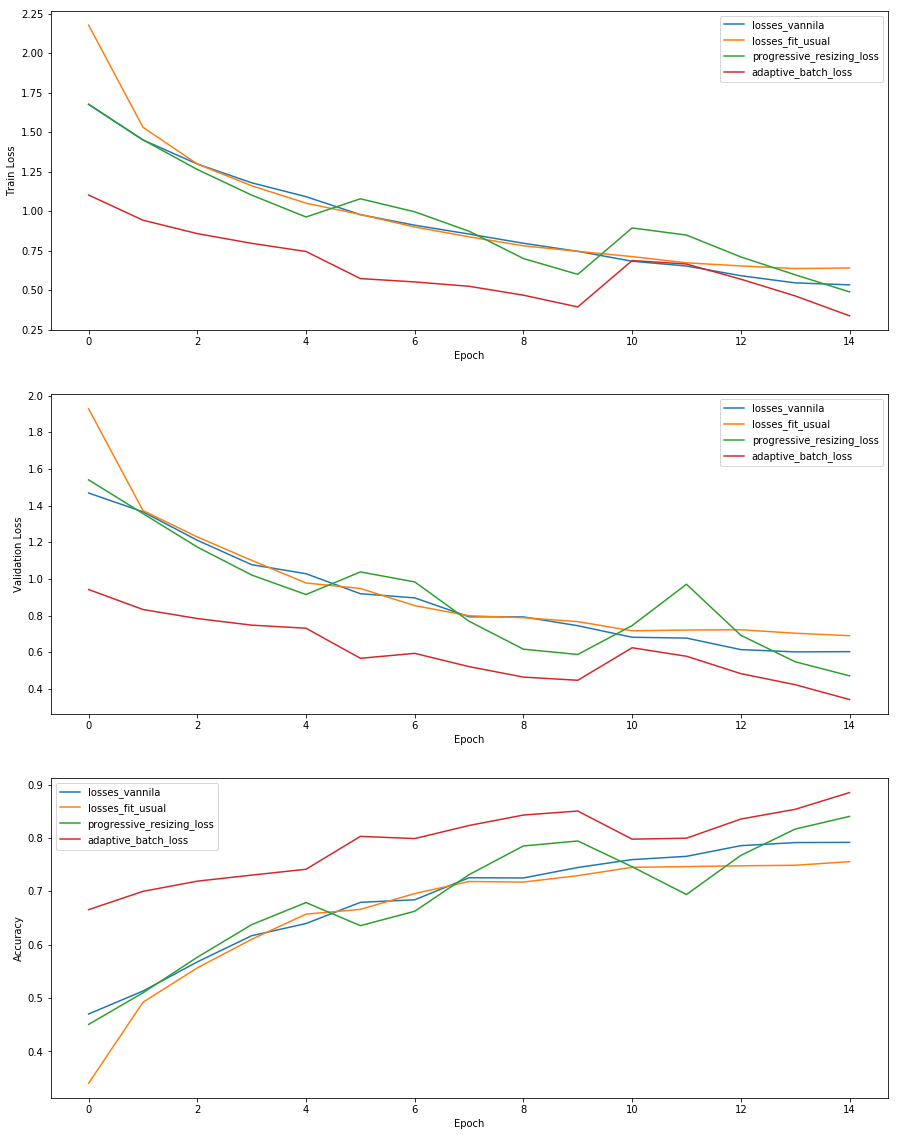

In [22]:
# plot Validation Loss Across all Apporaches 
fig,ax = plt.subplots(3,1,figsize=(15,20))
ax[0].plot(list(range(cycle_len)),losses_vannila[0], label='losses_vannila')
ax[0].plot(list(range(cycle_len)),losses_fit_usual[0], label='losses_fit_usual')
ax[0].plot(list(range(cycle_len)),progressive_resizing_loss[0], label='progressive_resizing_loss')
ax[0].plot(list(range(cycle_len)),adaptive_batch_loss[0], label='adaptive_batch_loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Train Loss')
ax[0].legend(loc='upper right')

ax[1].plot(list(range(cycle_len)),losses_vannila[1], label='losses_vannila')
ax[1].plot(list(range(cycle_len)),losses_fit_usual[1], label='losses_fit_usual')
ax[1].plot(list(range(cycle_len)),progressive_resizing_loss[1], label='progressive_resizing_loss')
ax[1].plot(list(range(cycle_len)),adaptive_batch_loss[1], label='adaptive_batch_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation Loss')
ax[1].legend(loc='upper right')

ax[2].plot(list(range(cycle_len)),losses_vannila[2], label='losses_vannila')
ax[2].plot(list(range(cycle_len)),losses_fit_usual[2], label='losses_fit_usual')
ax[2].plot(list(range(cycle_len)),progressive_resizing_loss[2], label='progressive_resizing_loss')
ax[2].plot(list(range(cycle_len)),adaptive_batch_loss[2], label='adaptive_batch_loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].legend(loc='bottom right')



# To Do : 
- Increase Cycle length for later stages and train less in earlier stages (Instead of splitting them equaly across all sizes)
